Firstly, we calculate the first three eigenstates of Fluxonium qubit

$$H=4 E_{C} \hat{n}^{2}+\frac{1}{2} E_{L} \hat{\varphi}^{2}-E_{J} \cos \left(\hat{\varphi}-2 \pi \frac{\Phi_{\text {ext }}}{\Phi_{0}}\right)$$

In [1]:
import jax
from jax import jit, vmap, grad
from jax import random
import jax.numpy as jnp
from jax import vjp

from jax.experimental import ode, optimizers
from jax.experimental.ode import odeint

from jax.config import config  # Force Jax use float64 as default Float dtype
config.update("jax_enable_x64", True)

key = random.PRNGKey(42)

sx= jnp.array([[0,1],[1,0]],dtype=jnp.float64)

In [2]:
import numpy as np 
from scipy.linalg import eigh 

#we set mu = hbar = 1

#mesh of the finite difference 
xmin = -10; xmax = 10; Nmesh = 2000
xmesh = jnp.linspace(xmin, xmax, Nmesh)

p0 = 0.5
Ej , Ec , El= 8.97, 2.47, 0.520

h = xmesh[1] - xmesh[0]

@jit
def buildH(p,Ec,El,Ej):
    Vx = jnp.array([0.5*El*x**2-Ej*jnp.cos(x-2*jnp.pi*p) for x in xmesh])
    H = jnp.diag(Vx) 
    return H - jnp.eye(Nmesh)*(Ec*8./(h*h))+ (jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h)

energies: [-246756.36783604 -246756.36543145 -246750.31074667]
E = 0.0


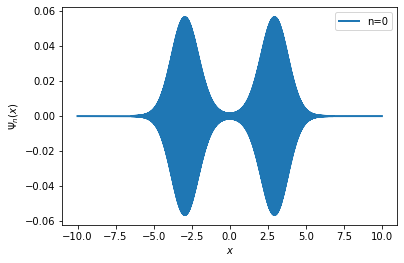

E = 0.0024045901955105364


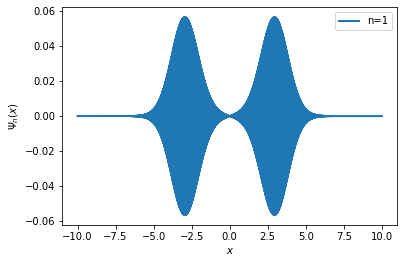

E = 6.057089369453024


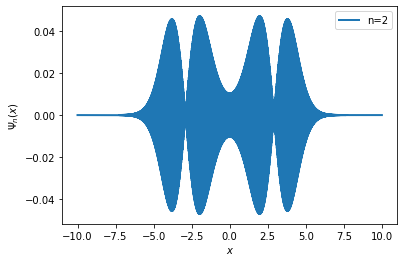

In [3]:
H = buildH(p0,Ec,El,Ej)
w, v = eigh(H)

nlowest = 3
print ('energies:', w[0:nlowest])

E0 = w[0]

import matplotlib.pyplot as plt
#plt.plot(xmesh, [Vpot(x) for x in xmesh], 'k-', lw=2)

for n in range(nlowest):
    print(f"E = {w[n]-w[0]}")
    plt.figure(n)
    plt.plot(xmesh, v[:,n], label='n=%g'%(n), lw=2)
    plt.xlabel('$x$')
    plt.ylabel('$\Psi_{n}(x)$')
    plt.legend()
    plt.show()

One of prominent features of Fluxonium is its large energy gap between computational qubit states and excited states. Due to this feature, we can project the wavefunction and Hamiltonian into the qubit computational subspace.

$$ P = |e\rangle\langle e|+|g\rangle\langle g|$$

In [4]:
P_sub = v[:,0:2]

@jit
def H_sub(p,Ec=Ec,El=El,Ej=Ej):
    H_real = buildH(p,Ec,El,Ej)
    return P_sub.T@H_real@P_sub - E0*jnp.eye(2)

In [5]:
%timeit H_sub(0)

67 µs ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Til now we can try optmize control in this sub system, for example $\sigma_x$ gate

In [39]:
@jit
def A(t,p,t1):
    '''
    Control field phi
    '''
    w = jnp.pi/t1
    N1, = jnp.shape(p)
    ft = jnp.array([jnp.sin(w*(i+1)*t) for i in range(N1)])
    return p@ft+p0

@jit
def loss(t1,flat_p,U_T):
    '''
    define the loss function, which is a pure function
    '''
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(U_T)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix

    @jit
    def func(y, t, *args):
        t1,flat_p, = args
        PHI = A(t,flat_p,t1)
        return -1.0j*H_sub(PHI)@y

    res = odeint(func, U_0, t_set, t1, flat_p,
                 rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, :,:]
#     print(U_F)
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/D)**2)

In [7]:
from scipy.optimize import minimize

def GateOptimize_LBFGS(U_F, t1, Ec,El,Ej, init_param,):
    '''
    Implementation with LBFGS
    '''
    loss_list = []
    def fun(p,*args):
        t0, p0 = p[0], p[1:]
        f, (gt,gp) = jax.value_and_grad(loss,(0,1))(t0,p0,Ec,El,Ej,U_F)
        gd = np.concatenate([np.array([gt]),gp])
        loss_list.append(f)
        return f, gd
    
    results = minimize(fun,np.concatenate([np.array([t1]),init_param]), method='L-BFGS-B', jac=True, 
                       options={'gtol': 1e-07})
    return loss_list,results.x

In [ ]:
N1 = 10
p = random.normal(key,shape=(N1,)) # Normal initialization
t1 = 1. 

%time loss(t1,p,sx)

# loss_list_LBFGS,res = GateOptimize_LBFGS(sx,t1,Ec,El,Ej,p)
# t_f,p_f = res[0],res[1:]

CPU times: user 1min 25s, sys: 3.89 s, total: 1min 29s
Wall time: 1min 29s


In [9]:
phi_list = np.linspace(0.,1.,10)
H11 = vmap(H_sub,in_axes=(0),out_axes=(0))(phi_list)

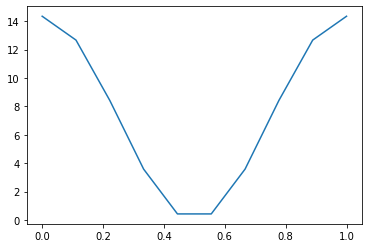

In [10]:
plt.plot(phi_list,H11[:,0,0])
plt.show()

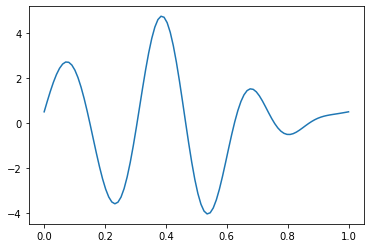

In [21]:
t_list = jnp.linspace(0.,t1,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,p,t1)

plt.plot(t_list,A_list)
plt.show()